In [ ]:
%matplotlib inline
import matplotlib
import nltk

# A bit of new python

### Dictionaries

In [ ]:
age_dict = {}
age_dict["Bruce"] = 55
age_dict["Leah"] = 21
age_dict["Mia"] = 18
age_dict["Hal"] = "not available"

In [ ]:
age_dict

### More about `for` loops

In [ ]:
name_list = ["Bruce", "Leah", "Mia"]

In [ ]:
for name in name_list:
    print(name)

In [ ]:
for name in name_list:
    print(name, age_dict[name])

In [ ]:
for n in range(7):
    print(n)

### List comprehensions

**List comprehensions** are a special bit of python syntex. They provide very, very compact ways of quickly building lists. They are extremely powerful, but hard to read, especially at first. 

I originally promised myself I would never use them, since I like my code to be readable. But they're so useful, and take so little typing, that I eventually caved. 

In [ ]:
lower_case_names = [name.lower() for name in name_list]
lower_case_names

In [ ]:
age_list = [age_dict[name] for name in name_list]
age_list

# Bigrams

In [ ]:
some_text = "now is the time for all good people to come to the aid of their country"
some_text_tokenized = nltk.word_tokenize(some_text)
list(nltk.bigrams(some_text_tokenized))

In [ ]:
list(nltk.trigrams(some_text_tokenized))

# Back to the beginning (Genesis)

In [ ]:
mygenesis = nltk.corpus.PlaintextCorpusReader("corpora", 'genesis.txt')

In [ ]:
genesis_words = [w.lower() for w in mygenesis.words()]
genesis_sents_upper = mygenesis.sents()
genesis_sents = []
for sent in genesis_sents_upper:
    new_sent = [w.lower() for w in sent]
    genesis_sents.append(new_sent)

In [ ]:
from nltk import FreqDist
word_fdist = FreqDist(genesis_words)

In [ ]:
word_fdist.most_common(10)

# Bigrams in genesis

In [ ]:
bigram_fdist = nltk.FreqDist()
for sent in genesis_sents:
    sent_bigrams = nltk.bigrams(sent)
    bigram_fdist.update(sent_bigrams)

In [ ]:
most_common_bigrams = bigram_fdist.most_common(25)
most_common_bigrams

We are interested in finding **collocations**. Collocations are pairs of words, or phrases, that have limited compositionality. This means that the meaning of the phrase cannot be determined simply from the meaning of the parts. The whole thing is, from a meaning point of view, a unit.

To get started, let's first just try pruning some of the obviously uninteresting bigrams from our list

In [ ]:
ignore_list = list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’')
ignore_list += list("abcdefghijklmnopqrstuvwxyz0123456789")
print(ignore_list)

In [ ]:
most_common_bigrams = bigram_fdist.most_common(100)
most_common_pruned = []
for bg_entry in most_common_bigrams:
    if bg_entry[0][0] in ignore_list or bg_entry[0][1] in ignore_list:
        continue
    most_common_pruned.append(bg_entry)

In [ ]:
most_common_pruned[:50]

In [ ]:
f = open("lists/stop-words_english_5_en.txt")
stop_list = set(f.read().split("\n"))
ignore_list += stop_list

In [ ]:
most_common_bigrams = bigram_fdist.most_common(500)
most_common_pruned = []
for bg_entry in most_common_bigrams:
    if bg_entry[0][0] in ignore_list or bg_entry[0][1] in ignore_list:
        continue
    most_common_pruned.append(bg_entry)

In [ ]:
most_common_pruned[:50]

In [ ]:
olden_stop_words = ["unto", "thou", "hast", "thee", "thy", "ye", "shall", "art", "hath", "thy", "said", "did"]
ignore_list += olden_stop_words

In [ ]:
most_common_bigrams = bigram_fdist.most_common(2000)
most_common_pruned = []
for bg_entry in most_common_bigrams:
    if bg_entry[0][0] in ignore_list or bg_entry[0][1] in ignore_list:
        continue
    most_common_pruned.append(bg_entry)

The cell below uses a little trick to help us display tables more nicely in the notebook.

In [ ]:
class ListTable(list):
    def _repr_html_(self):
        html = ["<table style= 'border: 1px solid black;''>"]
        for row in self:
            html.append("<tr>")
            for col in row:
                html.append("<td align='left' style='border: .5px solid gray;''>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [ ]:
test_table = ListTable()
test_table.append(["first", "second", "third"])
test_table.append(["some data", "more data", "yet more data"])
test_table.append(["3", "5", "7"])
test_table

In [ ]:
t = ListTable()
t.append(["w1", "w2", "freq"])
for mc in most_common_pruned[:25]:
    t.append([mc[0][0], mc[0][1], mc[1]])
t

# Are some bigrams more common than to be expected?

## t_test as measure

In [ ]:
p_begat = word_fdist["begat"] / word_fdist.N()
print("P(begat)=" + str(p_begat))

p_sons = word_fdist["sons"] / word_fdist.N()
print("P(sons)=" + str(p_sons))

p_product = word_fdist["begat"] * word_fdist["sons"] / (word_fdist.N() * word_fdist.N())
print("P(product)=" + str(p_product))

p_observed = bigram_fdist[("begat", "sons")] / word_fdist.N()
print("P(product)=" + str(p_observed))

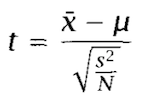

In [ ]:
import math
def student_t(w1, w2):
    mu = word_fdist[w1] * word_fdist[w2] / (word_fdist.N() * word_fdist.N())
    x = bigram_fdist[(w1, w2)] / word_fdist.N()
    s_squared = x
    denom = math.sqrt(s_squared / word_fdist.N())
    return (x - mu) / denom

In [ ]:
student_t("begat", "sons")

In [ ]:
t = ListTable()
t.append(["w1", "w2", "freq", "score"])
for mc in most_common_pruned[:25]:
    w1 = mc[0][0]
    w2 = mc[0][1]
    t.append([w1, w2, mc[1], round(student_t(w1, w2), 3)])
t

### Highest t-test scores overall

In [ ]:
res_dict = {}
res_list = []
for k in bigram_fdist.keys():
    if k[0] in ignore_list or k[1] in ignore_list:
        continue
    score = student_t(k[0], k[1])
    res_dict[k] = score
    res_list.append([k[0], k[1], bigram_fdist[(k[0], k[1])], round(score, 3)])
res_list.sort(key=lambda x: x[3], reverse=True)
table = ListTable()
table.append(["w1", "w2", "freq", "score"])
table += res_list[:25]
table

http://www.nltk.org/howto/collocations.html

# Exploration of word co-occurrences

In [ ]:
pruned_genesis_words = [w for w in genesis_words if w not in ignore_list]
pruned_genesis_sents = []
for sent in genesis_sents:
    new_sent = [w for w in sent if w not in ignore_list]
    pruned_genesis_sents.append(new_sent)

In [ ]:
import nltk
pword_fdist = nltk.FreqDist()
pword_fdist.update(pruned_genesis_words)

In [ ]:
most_common = [w[0] for w in pword_fdist.most_common(50)]

In [ ]:
import nltk
import copy
pword_fdist = nltk.FreqDist()
mrow = [0 for r in most_common]
mat = [copy.copy(mrow) for r in most_common]
for sent in genesis_sents:
    for n1, w1 in enumerate(most_common):
        if w1 in sent:
            for n2, w2 in enumerate(most_common):
                if w2 in sent:
                    mat[n1][n2] += 1

## Matplotlib digression

https://matplotlib.org/api/pyplot_summary.html

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1, 3, 4, 2])

In [ ]:
plt.plot([1, 3, 4, 2], "bo")

In [ ]:
plt.bar([1, 2, 3, 4], [1, 3, 4, 2])

## Back to co-occurrence

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
n = len(most_common)
x_tick_marks = np.arange(n)
y_tick_marks = np.arange(n)
plt.xticks(x_tick_marks, most_common, fontsize=8, rotation=90)
plt.yticks(y_tick_marks, most_common, fontsize=8)
plt.tick_params("x", top=True, labeltop=True, bottom=False, labelbottom=False)
plt.imshow(mat, norm=matplotlib.colors.LogNorm(), interpolation='nearest', cmap='YlOrBr')

In [ ]:
import itertools
possible_pairs = list( itertools.combinations(most_common[:25], 2)) 

In [ ]:
import networkx as nx
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
G2 = nx.Graph()
for pair in possible_pairs:
    wgt = mat[most_common.index(pair[0])][most_common.index(pair[1])]
    G2.add_edge(pair[0], pair[1], weight=wgt)
widths = list(nx.get_edge_attributes(G2, "weight").values())
widths = [w / 35 for w in widths]
pos = nx.spring_layout(G2, iterations=40, weight="weight") 
nx.draw(G2, pos, k=.01, with_labels=True, width=widths, node_color="gold", edge_color="orange")

# A new corpus: The journal MTMS going back to 2007

## Some machinery to read in the corpus

This uses some more advanced python. Look at it if you want, but I'm assuming you'll ignore it for now.

In [ ]:
import csv
import nltk
import os

class mtms_document:
    def __init__(self, base, filename):
        csvfile = open(base + "/" + filename)
        csv_reader = csv.DictReader(csvfile, delimiter=",")
        self._filename = filename
        self._paragraphs = []
        self._sentences = []
        self._words = []
        for r in csv_reader:
            raw_sentences = nltk.sent_tokenize(r["text"])
            new_sentences = [nltk.word_tokenize(sent) for sent in raw_sentences]
            self._sentences += new_sentences
            new_words = []
            for sent in new_sentences:
                new_words += sent
                self._paragraphs.append(new_words)
            self._words += new_words
        return
            
    def words(self):
        return self._words
    
    def paragraphs(self):
        return self._paragraphs
    
    def sentences(self):
        return self._sentences
    
    def name(self):
        return self._filename
    
class mtms_reader:
    def __init__(self):
        self.base = "corpora/mtms_csv"
        self._name_list = os.listdir(self.base)
        self.mtms_docs = {}
        self._words = []
        self._sentences = []
        self._paragraphs = []
        self._document_list = []
        ndocs = len(name_list)
        for n, fname in enumerate(self._name_list):
            if n % 100 == 0:
                print("processing doc {} of {}".format(n, ndocs))
            new_doc = mtms_document(self.base, fname)
            self.mtms_docs[fname] = new_doc
            self._words += new_doc.words()
            self._sentences += new_doc.sentences()
            self._paragraphs += new_doc.paragraphs()
        return
    
    def document_names(self):
        return self._name_list
    
    def words(self):
        return self._words
    
    def sentences(self):
        return self._sentences
    
    def paragraphs(self):
        return self._paragraphs
    
    def __getitem__(self, docname):
        return self.mtms_docs[docname]

## Read in the new corpus

In [ ]:
mr = mtms_reader()

You can access the words, sentences, and paragraphs like so

In [ ]:
print(mr.words()[:25])
print(mr.sentences()[9])
print(mr.paragraphs()[9])

You can also work with individual files, if you want.

In [ ]:
print(mr.document_names()[:2])

In [ ]:
doc = mr["mtms2012-12-286a-Table 1.csv"]

In [ ]:
print(doc.words()[:25])